# Correlation

In [1]:
%reload_ext autoreload

%autoreload 2

import math
import os

import iris
import iris.analysis.cartography
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from ml_downscaling_emulator import UKCPDatasetMetadata
from ml_downscaling_emulator.helpers import plot_over_ts
from ml_downscaling_emulator.utils import cp_model_rotated_pole, platecarree, plot_grid, open_samples_ds, show_samples

In [2]:
split = "val"
dataset_name = "2.2km-coarsened-gcm-2.2km_london_vorticity850_random"
# gcm_derived_dataset_name = "60km-2.2km_london_vorticity850_random"

run_name = "2.2km-coarsened-gcm_london_vorticity850_random"
checkpoint_id = 17

In [3]:
pred_ds = open_samples_ds(run_name, checkpoint_id, dataset_name, split).isel(sample_id=[0,1])
# gcm_derived_samples_ds = open_samples_ds(run_name, checkpoint_id, gcm_derived_dataset_name, split)
eval_ds = xr.open_dataset(os.path.join(os.getenv("MOOSE_DERIVED_DATA"), "nc-datasets", dataset_name, f"{split}.nc"))

# convert from kg m-2 s-1 (i.e. mm s-1) to mm day-1
pred_ds["pred_pr"] = (pred_ds["pred_pr"]*3600*24 ).assign_attrs({"units": "mm day-1"})
# gcm_derived_samples_ds["pred_pr"] = (gcm_derived_samples_ds["pred_pr"]*3600*24 ).assign_attrs({"units": "mm day-1"})
eval_ds["target_pr"] = (eval_ds["target_pr"]*3600*24).assign_attrs({"units": "mm day-1"})

merged_ds = xr.merge([pred_ds, eval_ds], join="inner").isel(time=slice(10))

merged_ds

<xarray.Dataset>
Dimensions:                     (time: 10, sample_id: 2, bnds: 2,
                                 grid_latitude: 64, grid_longitude: 64)
Coordinates:
  * time                        (time) object 1980-12-03 12:00:00 ... 1981-02...
    forecast_period             (time) timedelta64[ns] 452 days 12:00:00 ... ...
    forecast_reference_time     (time) object 1979-09-01 00:00:00 ... 1979-09...
    realization                 (time) int32 1100000 1100000 ... 1100000 1100000
    season                      (time) int64 0 0 0 0 0 0 0 0 0 0
  * grid_latitude               (grid_latitude) float32 -1.58 -1.56 ... -0.32
  * grid_longitude              (grid_longitude) float32 360.9 360.9 ... 362.1
  * sample_id                   (sample_id) int64 0 1
Dimensions without coordinates: bnds
Data variables:
    rotated_latitude_longitude  (sample_id, time) float64 -2.147e+09 ... -2.1...
    time_bnds                   (sample_id, time, bnds) object 1980-12-03 00:...
    grid_latitude_bnds          (sample_id, time, grid_latitude, bnds) float32 ...
    grid_longitude_bnds         (sample_id, time, grid_longitude, bnds) float32 ...
    pred_pr                     (sample_id, time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(1, 10, 64, 64), meta=np.ndarray>
    forecast_period_bnds        (time, bnds) float64 ...
    target_pr                   (time, grid_latitude, grid_longitude) float32 ...
    vorticity850                (time, grid_latitude, grid_longitude) float64 ...

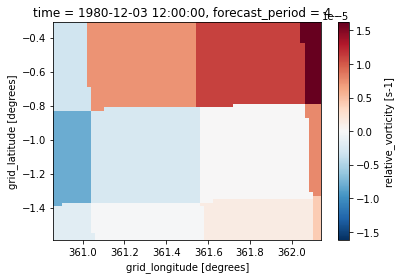

(12, 10)

In [4]:
# fig, axd = plt.subplot_mosaic([["Sample", "Target"]], figsize=(12, 6), subplot_kw=dict(projection=cp_model_rotated_pole), constrained_layout=True)

merged_ds["vorticity850"].isel(time=0).plot()
plt.show()
merged_ds["vorticity850"].isel(grid_longitude=[0, 20, 40, 63], grid_latitude=[0, 31, 63]).values.reshape(-1, 12).T.shape

In [5]:
merged_ds = merged_ds.assign_coords(gcm_box_idx=np.arange(12))

In [6]:
uniq_inputs_data = merged_ds["vorticity850"].isel(grid_longitude=[0, 20, 40, 63], grid_latitude=[0, 31, 63]).values.reshape(-1, 12)

In [7]:
merged_ds["uniq_inputs"] = xr.DataArray(data=uniq_inputs_data, coords=[merged_ds["time"], merged_ds["gcm_box_idx"]])

In [8]:
inputs_corr = xr.corr(merged_ds["uniq_inputs"], merged_ds["target_pr"], dim="time")
inputs_corr

<xarray.DataArray (gcm_box_idx: 12, grid_latitude: 64, grid_longitude: 64)>
array([[[-0.51612365, -0.50076186, -0.47279189, ..., -0.40774759,
         -0.35162424, -0.32131866],
        [-0.50949078, -0.50748004, -0.49008781, ..., -0.45148684,
         -0.37651785, -0.30966929],
        [-0.46643451, -0.47381169, -0.47201639, ..., -0.47527564,
         -0.41522093, -0.30205598],
        ...,
        [-0.2554442 , -0.19693549, -0.15648659, ...,  0.34095776,
          0.37420914,  0.40944535],
        [-0.30816995, -0.27361668, -0.23552979, ...,  0.36384864,
          0.38135055,  0.4074798 ],
        [-0.31894123, -0.30066114, -0.28511808, ...,  0.40915128,
          0.42402072,  0.43861732]],

       [[-0.55072142, -0.5383535 , -0.51564516, ..., -0.41733409,
         -0.36964057, -0.34371596],
        [-0.54609574, -0.54493643, -0.53131003, ..., -0.45330192,
         -0.38847336, -0.33118168],
        [-0.51264689, -0.51971503, -0.51915673, ..., -0.47281317,
         -0.4199841 , -0.32244708],
...
        [-0.20188104, -0.17226369, -0.14796891, ...,  0.1059693 ,
          0.12476743,  0.1439739 ],
        [-0.24405839, -0.23291456, -0.21340024, ...,  0.14352783,
          0.1560748 ,  0.17087333],
        [-0.24869109, -0.24843446, -0.24689164, ...,  0.18190568,
          0.19469816,  0.20730713]],

       [[-0.42291803, -0.42717647, -0.42668175, ..., -0.38269499,
         -0.39113586, -0.41342985],
        [-0.42466453, -0.43338419, -0.43963155, ..., -0.38917944,
         -0.37002543, -0.37470519],
        [-0.42413121, -0.43601035, -0.44598061, ..., -0.40926804,
         -0.37296539, -0.34643436],
        ...,
        [-0.04828138, -0.01840426,  0.00743732, ..., -0.09898609,
         -0.08298069, -0.06710484],
        [-0.11417711, -0.10685704, -0.08465101, ..., -0.05045409,
         -0.03712901, -0.02417109],
        [-0.12056952, -0.12935128, -0.13483174, ..., -0.00443941,
          0.00883122,  0.02110748]]])
Coordinates:
  * gcm_box_idx     (gcm_box_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * grid_latitude   (grid_latitude) float32 -1.58 -1.56 -1.54 ... -0.3399 -0.32
  * grid_longitude  (grid_longitude) float32 360.9 360.9 360.9 ... 362.1 362.1

In [19]:
inputs_sample_corr = xr.corr(merged_ds["uniq_inputs"], merged_ds["pred_pr"], dim="time")
inputs_sample_corr

<xarray.DataArray (gcm_box_idx: 12, sample_id: 2, grid_latitude: 64,
                   grid_longitude: 64)>
dask.array<truediv, shape=(12, 2, 64, 64), dtype=float64, chunksize=(12, 1, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * gcm_box_idx     (gcm_box_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * grid_latitude   (grid_latitude) float32 -1.58 -1.56 -1.54 ... -0.3399 -0.32
  * grid_longitude  (grid_longitude) float32 360.9 360.9 360.9 ... 362.1 362.1
  * sample_id       (sample_id) int64 0 1

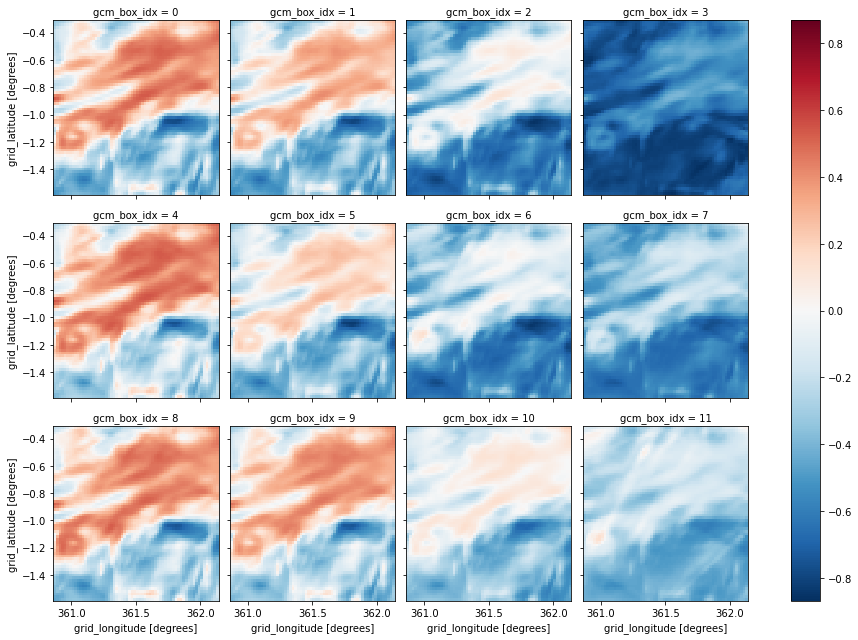

In [9]:
inputs_corr.plot(col="gcm_box_idx", col_wrap=4)

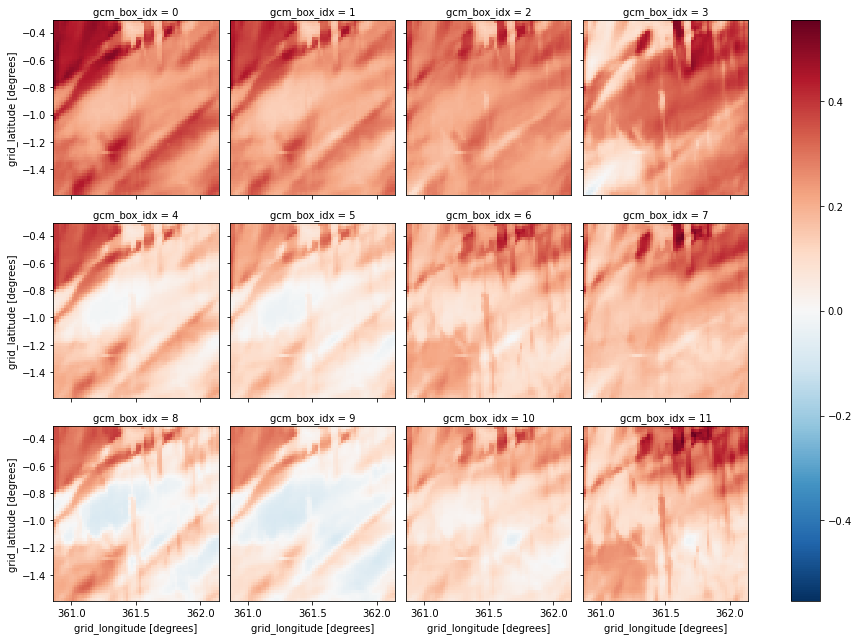

In [28]:
inputs_sample_corr.mean(dim="sample_id").plot(col="gcm_box_idx", col_wrap=4)

In [24]:
xr.corr(merged_ds["vorticity850"].isel(grid_longitude=20, grid_latitude=31), merged_ds["pred_pr"].isel(grid_longitude=0, grid_latitude=0, sample_id=1), dim="time").values

array(0.08102769)

In [22]:
inputs_sample_corr.isel(grid_longitude=0, grid_latitude=0).values[:, 1]

array([ 0.35141004,  0.26151643,  0.24708155,  0.22943148,  0.18642851,
        0.08102769,  0.06954673,  0.08301948,  0.0781007 ,  0.02269753,
       -0.02252265, -0.03182787])